In [122]:
import pandas as pd
from math import ceil
import matplotlib.pyplot as plt
import matplotlib
import textwrap


In [123]:
def wrap(s, w):
    arr = textwrap.wrap(s, w)
    new_s = ""
    for i,a in enumerate(arr):
        new_s  += a 
        if i != len(arr) - 1:       
            new_s  += "\n" 
    return new_s

In [124]:
R_F, R_P = 8, 56
c, r = 1, 2
R_i, R_e, R_h = 41, 6, 39

In [125]:
t = 8
def g(t):
    """
    Assumes 4 word input for hash/t word input for encryption
    t word output for both
    Returns:
      0 - number of multiplications [triples for MPC, constraints for R1CS]
      1 - number of rounds for MPC (after batching)
    """
    return 2 * R_i + 4 * 3 * R_e + ceil(t/8) * (2 + R_h) - 2, 2 * R_i + 3 * R_e + ceil(t/8) - 1 + R_h 

In [126]:
#Copied from https://extgit.iaik.tugraz.at/krypto/hadeshash/-/blob/master/code/calc_round_numbers.py?ref_type=heads for generating round numbers here
from math import *
import sys
import Crypto.Util.number

def sat_inequiv_alpha(p, t, R_F, R_P, alpha, M):
    n = ceil(log(p, 2))
    N = int(n * t)
    if alpha > 0:
        R_F_1 = 6 if M <= ((floor(log(p, 2) - ((alpha-1)/2.0))) * (t + 1)) else 10 # Statistical
        R_F_2 = 1 + ceil(log(2, alpha) * min(M, n)) + ceil(log(t, alpha)) - R_P # Interpolation
        #R_F_3 = ceil(min(n, M) / float(3*log(alpha, 2))) - R_P # Groebner 1
        #R_F_3 = ((log(2, alpha) / float(2)) * min(n, M)) - R_P # Groebner 1
        R_F_3 = 1 + (log(2, alpha) * min(M/float(3), log(p, 2)/float(2))) - R_P # Groebner 1
        R_F_4 = t - 1 + min((log(2, alpha) * M) / float(t+1), ((log(2, alpha)*log(p, 2)) / float(2))) - R_P # Groebner 2
        #R_F_5 = ((1.0/(2*log((alpha**alpha)/float((alpha-1)**(alpha-1)), 2))) * min(n, M) + t - 2 - R_P) / float(t - 1) # Groebner 3
        R_F_max = max(ceil(R_F_1), ceil(R_F_2), ceil(R_F_3), ceil(R_F_4))
        return (R_F >= R_F_max)
    elif alpha == (-1):
        R_F_1 = 6 if M <= ((floor(log(p, 2) - 2)) * (t + 1)) else 10 # Statistical
        R_P_1 = 1 + ceil(0.5 * min(M, n)) + ceil(log(t, 2)) - floor(R_F * log(t, 2)) # Interpolation
        R_P_2 = 1 + ceil(0.5 * min(M, n)) + ceil(log(t, 2)) - floor(R_F * log(t, 2))
        R_P_3 = t - 1 + ceil(log(t, 2)) + min(ceil(M / float(t+1)), ceil(0.5*log(p, 2))) - floor(R_F * log(t, 2)) # Groebner 2
        R_F_max = ceil(R_F_1)
        R_P_max = max(ceil(R_P_1), ceil(R_P_2), ceil(R_P_3))
        return (R_F >= R_F_max and R_P >= R_P_max)
    else:
        print("Invalid value for alpha!")
        exit(1)

def get_sbox_cost(R_F, R_P, N, t):
    return int(t * R_F + R_P)

def get_size_cost(R_F, R_P, N, t):
    n = ceil(float(N) / t)
    return int((N * R_F) + (n * R_P))

def get_depth_cost(R_F, R_P, N, t):
    return int(R_F + R_P)

def find_FD_round_numbers(p, t, alpha, M, cost_function, security_margin):
    n = ceil(log(p, 2))
    N = int(n * t)

    sat_inequiv = sat_inequiv_alpha
    
    R_P = 0
    R_F = 0
    min_cost = float("inf")
    max_cost_rf = 0
    # Brute-force approach
    for R_P_t in range(1, 500):
        for R_F_t in range(4, 100):
            if R_F_t % 2 == 0:
                if (sat_inequiv(p, t, R_F_t, R_P_t, alpha, M) == True):
                    if security_margin == True:
                        R_F_t += 2
                        R_P_t = int(ceil(float(R_P_t) * 1.075))
                    cost = cost_function(R_F_t, R_P_t, N, t)
                    if (cost < min_cost) or ((cost == min_cost) and (R_F_t < max_cost_rf)):
                        R_P = ceil(R_P_t)
                        R_F = ceil(R_F_t)
                        min_cost = cost
                        max_cost_rf = R_F
    return (int(R_F), int(R_P))

def calc_final_numbers_fixed(p, t, alpha, M, security_margin):
    # [Min. S-boxes] Find best possible for t and N
    n = ceil(log(p, 2))
    N = int(n * t)
    cost_function = get_sbox_cost
    ret_list = []
    (R_F, R_P) = find_FD_round_numbers(p, t, alpha, M, cost_function, security_margin)
    min_sbox_cost = cost_function(R_F, R_P, N, t)
    ret_list.append(R_F)
    ret_list.append(R_P)
    ret_list.append(min_sbox_cost)

    # [Min. Size] Find best possible for t and N
    # Minimum number of S-boxes for fixed n results in minimum size also (round numbers are the same)!
    min_size_cost = get_size_cost(R_F, R_P, N, t)
    ret_list.append(min_size_cost)

    return ret_list # [R_F, R_P, min_sbox_cost, min_size_cost]


pallas_prime =  0x40000000000000000000000000000000224698fc094cf91b992d30ed00000001




In [127]:
n = 2
o = 2
#Both assumes capacity is 1
def f(n,o, r):
    """
    Inputs:
    n - input length
    o - output length # not used for encryption. assumed n+2
    r - rate for Poseidon permutation
    Returns
    0 - #multiplications for n words to o words hash (sponge) [triples for MPC, constraints for R1CS]
    1 - #rounds for n words to o words hash (sponge) in MPC after batching
    2 - #rounds for encryption of n words (Poseidon, authenticated encryption using Duplex) in MPC after batching
    3 - #multiplications for encryption of n words (Poseidon, authenticated encryption using Duplex) in MPC after batching [triples for MPC, constraints for R1CS]
    """
    if constants.get(r) is not None:
        R_F, R_P = constants.get(r)
    else:
        R_F, R_P, _, __ = calc_final_numbers_fixed(pallas_prime, r+1, 5, 128, True)
        constants[r] = (R_F, R_P)
    return 3 * (R_F * (c+r) + R_P) * (ceil(n/r) + ceil(o/r) - 1), 3 * (R_F + R_P) * (ceil(n/r) + ceil(o/r) - 1) , 3 * (R_F + R_P) * (ceil(n/r) + 1), 3 * (R_F * (c+r) + R_P) * (ceil(n/r) + 1) 

constants = {}
def f_rate(n,o):
    """
    Same as f except rate is fixed as o
    """
    if constants.get(o) is not None:
        R_F, R_P = constants.get(o)
    else:
        R_F, R_P, _, __ = calc_final_numbers_fixed(pallas_prime, o+1, 5, 128, True)
        constants[o] = (R_F, R_P)
    return 3 * (R_F * (c+r) + R_P) * (ceil(n/r) + ceil(o/r) - 1), 3 * (R_F + R_P) * (ceil(n/r) + ceil(o/r) - 1) , 3 * (R_F + R_P) * (ceil(n/r) + 1), 3 * (R_F * (c+r) + R_P) * (ceil(n/r) + 1) 


In [128]:
imgs_path = "./plots/"

In [129]:
for n in [2,4,8]:
    for o in [2,4,8]:
        print(f(n,o, r))

print()
 
for t in [8,16,32,64]:
    print(g(t))

(240, 192, 384, 480)
(480, 384, 384, 480)
(960, 768, 384, 480)
(480, 384, 576, 720)
(720, 576, 576, 720)
(1200, 960, 576, 720)
(960, 768, 960, 1200)
(1200, 960, 960, 1200)
(1680, 1344, 960, 1200)

(193, 139)
(234, 140)
(316, 142)
(480, 146)


In [130]:
const_dict = {"Algorithm": [], "Output length": [], "Number of constraints": []}
os =  range(2,129)#[4,8,16,32,64,128]

for n in [4]:
    for o in os:
        for r in [2,4]:
            const_dict["Algorithm"].append(f"Poseidon with rate {r}")
            const_dict["Output length"].append(o)
            const_dict["Number of constraints"].append(f(n,o,r)[0])
        
        const_dict["Algorithm"].append(f"Hydra")
        const_dict["Output length"].append(o)
        const_dict["Number of constraints"].append(g(o)[0])        

\begin{table}
\caption{Number of R1CS constraints for Poseidon and Hydra hash functions for 4 words input.}
\begin{tabular}{llr}
\toprule
 &  & Number of constraints \\
Output length & Algorithm &  \\
\midrule
\multirow[t]{3}{*}{4} & Poseidon with rate 2 & 720 \\
 & Poseidon with rate 4 & 288 \\
 & Hydra & 193 \\
\cline{1-3}
\multirow[t]{3}{*}{8} & Poseidon with rate 2 & 1200 \\
 & Poseidon with rate 4 & 576 \\
 & Hydra & 193 \\
\cline{1-3}
\multirow[t]{3}{*}{16} & Poseidon with rate 2 & 2160 \\
 & Poseidon with rate 4 & 1152 \\
 & Hydra & 234 \\
\cline{1-3}
\multirow[t]{3}{*}{32} & Poseidon with rate 2 & 4080 \\
 & Poseidon with rate 4 & 2304 \\
 & Hydra & 316 \\
\cline{1-3}
\multirow[t]{3}{*}{64} & Poseidon with rate 2 & 7920 \\
 & Poseidon with rate 4 & 4608 \\
 & Hydra & 480 \\
\cline{1-3}
\bottomrule
\end{tabular}
\end{table}

                Algorithm  Output length  Number of constraints
1    Poseidon with rate 4              2                    288
4    Poseidon with rate 4   

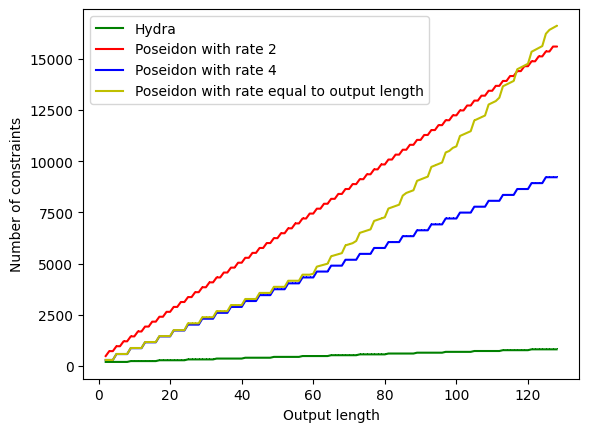

In [131]:
std_os = [4,8,16,32,64]
df = pd.DataFrame(const_dict)
print(df[df["Output length"].isin(std_os)]
      .set_index(["Output length", "Algorithm"])
      .to_latex(caption="Number of R1CS constraints for Poseidon and Hydra hash functions for 4 words input."))


#df[df["Algorithm"] == "Hydra"].plot()
#df[df["Algorithm"] == "Poseidon with rate 2"].plot()
#df = df.reset_index()
#df.groupby("Algorithm").plot()

hydra_cols = df[df["Algorithm"]=="Hydra"]
pos2_cols = df[df["Algorithm"]=="Poseidon with rate 2"]
pos4_cols = df[df["Algorithm"]=="Poseidon with rate 4"]
print(pos4_cols)
plt.plot(hydra_cols["Output length"], hydra_cols["Number of constraints"],"g,-", label="Hydra")
plt.plot(pos2_cols["Output length"], pos2_cols["Number of constraints"],"r,-", label="Poseidon with rate 2")
plt.plot(pos4_cols["Output length"], pos4_cols["Number of constraints"],"b,-", label="Poseidon with rate 4")
plt.plot(os, [f_rate(4,o)[0] for o in os], "y,-", label="Poseidon with rate equal to output length")
print([f_rate(4,o)[0] for o in os])
plt.xlabel("Output length")
plt.ylabel("Number of constraints")
title = "R1CS efficiency of hash functions for 4 word inputs"
#plt.title(title)
plt.legend()
plt.savefig(imgs_path+title+".png")

In [132]:
const_dict_encryption = {"Algorithm": [], "Plaintext length": [], "Number of constraints": []}

ts =  [4,8,16,32,64,128]
for t in range(2,129):
    for r in [2]:
        const_dict_encryption["Algorithm"].append(f"Poseidon")
        const_dict_encryption["Plaintext length"].append(t)
        const_dict_encryption["Number of constraints"].append(f(t,t,r)[3])
    
    const_dict_encryption["Algorithm"].append(f"Hydra")
    const_dict_encryption["Plaintext length"].append(t)
    const_dict_encryption["Number of constraints"].append(g(t)[0])     

\begin{table}
\caption{Number of R1CS constraints for Poseidon and Hydra based encryption.}
\begin{tabular}{llr}
\toprule
 &  & Number of constraints \\
Plaintext length & Algorithm &  \\
\midrule
\multirow[t]{2}{*}{4} & Poseidon & 720 \\
 & Hydra & 193 \\
\cline{1-3}
\multirow[t]{2}{*}{8} & Poseidon & 1200 \\
 & Hydra & 193 \\
\cline{1-3}
\multirow[t]{2}{*}{16} & Poseidon & 2160 \\
 & Hydra & 234 \\
\cline{1-3}
\multirow[t]{2}{*}{32} & Poseidon & 4080 \\
 & Hydra & 316 \\
\cline{1-3}
\multirow[t]{2}{*}{64} & Poseidon & 7920 \\
 & Hydra & 480 \\
\cline{1-3}
\bottomrule
\end{tabular}
\end{table}



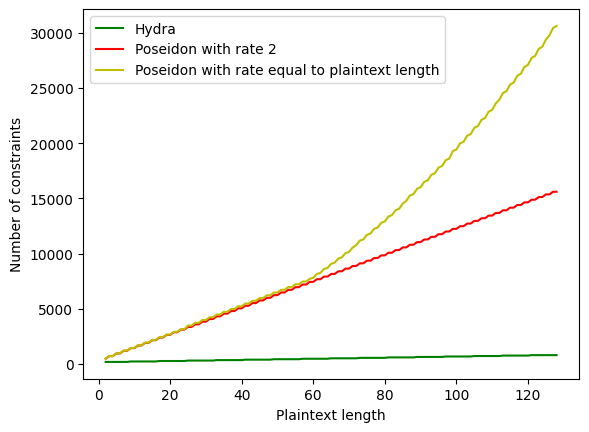

In [133]:
df = pd.DataFrame(const_dict_encryption)
print(df[df["Plaintext length"].isin(std_os)]
      .set_index(["Plaintext length", "Algorithm"])
      .to_latex(caption="Number of R1CS constraints for Poseidon and Hydra based encryption."))


hydra_cols = df[df["Algorithm"]=="Hydra"]
pos_cols = df[df["Algorithm"]=="Poseidon"]

plt.plot(hydra_cols["Plaintext length"], hydra_cols["Number of constraints"],"g-", label="Hydra")
plt.plot(pos_cols["Plaintext length"], pos_cols["Number of constraints"], "r-", label="Poseidon with rate 2")
plt.plot(range(2,129), [f_rate(o,o)[3] for o in range(2,129)],"y-", label="Poseidon with rate equal to plaintext length")

plt.xlabel("Plaintext length")
plt.ylabel("Number of constraints")
title = "R1CS efficiency of encryption"
#plt.title(title)
plt.legend()
plt.savefig(imgs_path+title+".png")

In [134]:
print(df.to_latex(index=False))

\begin{tabular}{lrr}
\toprule
Algorithm & Plaintext length & Number of constraints \\
\midrule
Poseidon & 2 & 480 \\
Hydra & 2 & 193 \\
Poseidon & 3 & 720 \\
Hydra & 3 & 193 \\
Poseidon & 4 & 720 \\
Hydra & 4 & 193 \\
Poseidon & 5 & 960 \\
Hydra & 5 & 193 \\
Poseidon & 6 & 960 \\
Hydra & 6 & 193 \\
Poseidon & 7 & 1200 \\
Hydra & 7 & 193 \\
Poseidon & 8 & 1200 \\
Hydra & 8 & 193 \\
Poseidon & 9 & 1440 \\
Hydra & 9 & 234 \\
Poseidon & 10 & 1440 \\
Hydra & 10 & 234 \\
Poseidon & 11 & 1680 \\
Hydra & 11 & 234 \\
Poseidon & 12 & 1680 \\
Hydra & 12 & 234 \\
Poseidon & 13 & 1920 \\
Hydra & 13 & 234 \\
Poseidon & 14 & 1920 \\
Hydra & 14 & 234 \\
Poseidon & 15 & 2160 \\
Hydra & 15 & 234 \\
Poseidon & 16 & 2160 \\
Hydra & 16 & 234 \\
Poseidon & 17 & 2400 \\
Hydra & 17 & 275 \\
Poseidon & 18 & 2400 \\
Hydra & 18 & 275 \\
Poseidon & 19 & 2640 \\
Hydra & 19 & 275 \\
Poseidon & 20 & 2640 \\
Hydra & 20 & 275 \\
Poseidon & 21 & 2880 \\
Hydra & 21 & 275 \\
Poseidon & 22 & 2880 \\
Hydra & 22 & 275 \\
Po

\begin{table}
\caption{Number of multiplication triples and communication rounds for computation of hash functions of Hydra and Poseidon in MPC (excluding the final opening)}
\begin{tabular}{llrr}
\toprule
 &  & Number of triples & Number of communication rounds \\
Output length & Algorithm &  &  \\
\midrule
\multirow[t]{3}{*}{4} & Poseidon with rate 2 & 720 & 576 \\
 & Poseidon with rate 4 & 288 & 192 \\
 & Hydra & 193 & 139 \\
\cline{1-4}
\multirow[t]{3}{*}{8} & Poseidon with rate 2 & 1200 & 960 \\
 & Poseidon with rate 4 & 576 & 384 \\
 & Hydra & 193 & 139 \\
\cline{1-4}
\multirow[t]{3}{*}{16} & Poseidon with rate 2 & 2160 & 1728 \\
 & Poseidon with rate 4 & 1152 & 768 \\
 & Hydra & 234 & 140 \\
\cline{1-4}
\multirow[t]{3}{*}{32} & Poseidon with rate 2 & 4080 & 3264 \\
 & Poseidon with rate 4 & 2304 & 1536 \\
 & Hydra & 316 & 142 \\
\cline{1-4}
\multirow[t]{3}{*}{64} & Poseidon with rate 2 & 7920 & 6336 \\
 & Poseidon with rate 4 & 4608 & 3072 \\
 & Hydra & 480 & 146 \\
\cline{1-4}


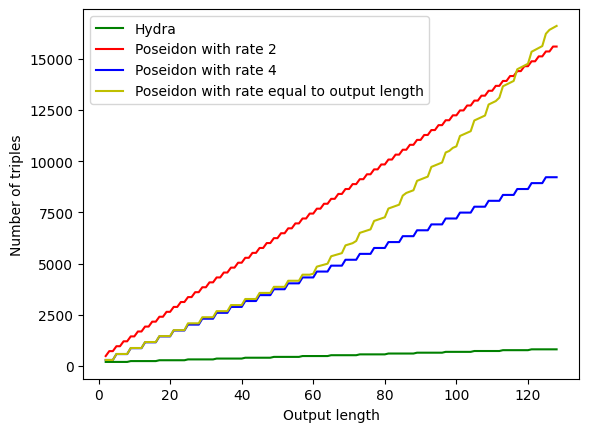

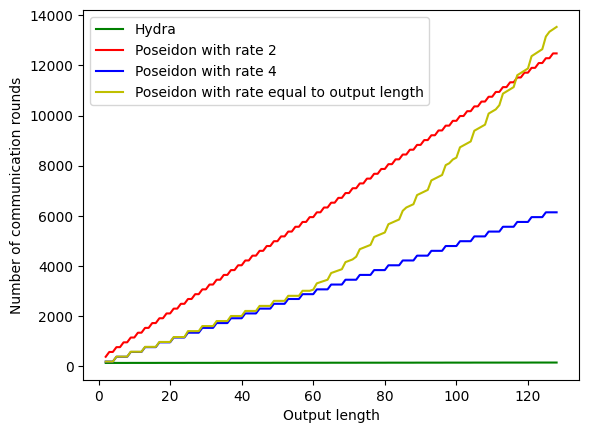

In [135]:
mpc_dict = {"Algorithm": [], "Output length": [], "Number of triples": [], "Number of communication rounds": []}

os = range(2,129)#[4,8,16,32,64,128]
for n in [4]:
    for o in os:
        for r in [2,4]:
            mpc_dict["Algorithm"].append(f"Poseidon with rate {r}")
            mpc_dict["Output length"].append(o)
            mpc_dict["Number of triples"].append(f(n,o,r)[0])
            mpc_dict["Number of communication rounds"].append(f(n,o,r)[1])
        
        mpc_dict["Algorithm"].append(f"Hydra")
        mpc_dict["Output length"].append(o)
        mpc_dict["Number of triples"].append(g(o)[0])
        mpc_dict["Number of communication rounds"].append(g(o)[1])

df = pd.DataFrame(mpc_dict)
print(df[df["Output length"].isin(std_os)]
      .set_index(["Output length", "Algorithm"])
      .to_latex(caption="Number of multiplication triples and communication rounds for computation of hash functions of Hydra and Poseidon in MPC (excluding the final opening)"))


hydra_cols = df[df["Algorithm"]=="Hydra"]
pos2_cols = df[df["Algorithm"]=="Poseidon with rate 2"]
pos4_cols = df[df["Algorithm"]=="Poseidon with rate 4"]
print(pos4_cols)

for i in ["triples", "communication rounds"]:
    plt.plot(hydra_cols["Output length"], hydra_cols[f"Number of {i}"],"g-", label="Hydra")
    plt.plot(pos2_cols["Output length"], pos2_cols[f"Number of {i}"], "r-", label="Poseidon with rate 2")
    plt.plot(pos4_cols["Output length"], pos4_cols[f"Number of {i}"],"b-", label="Poseidon with rate 4")
    if i == "triples":
        plt.plot(os, [f_rate(4,o)[0] for o in os],"y-", label="Poseidon with rate equal to output length")
        print([f_rate(4,o)[0] for o in os])
    elif i == "communication rounds":
        plt.plot(os, [f_rate(4,o)[1] for o in os],"y-", label="Poseidon with rate equal to output length")
        
    plt.xlabel("Output length")
    plt.ylabel(f"Number of {i}")
    title = f"MPC efficiency of hashing 4 words in terms of number of {i}"
    #plt.title(wrap(title, 65))
    plt.legend()
    plt.savefig(imgs_path+title+".png")
    plt.show()

\begin{table}
\caption{Number of multiplication triples and communication rounds for computation of ciphertext in Hydra and Poseidon in MPC (excluding the final opening)}
\begin{tabular}{llrr}
\toprule
 &  & Number of triples & Number of communication rounds \\
Output length & Algorithm &  &  \\
\midrule
\multirow[t]{3}{*}{4} & Poseidon with rate 2 & 720 & 576 \\
 & Poseidon with rate 4 & 576 & 384 \\
 & Hydra & 193 & 139 \\
\cline{1-4}
\multirow[t]{3}{*}{8} & Poseidon with rate 2 & 1200 & 960 \\
 & Poseidon with rate 4 & 864 & 576 \\
 & Hydra & 193 & 139 \\
\cline{1-4}
\multirow[t]{3}{*}{16} & Poseidon with rate 2 & 2160 & 1728 \\
 & Poseidon with rate 4 & 1440 & 960 \\
 & Hydra & 234 & 140 \\
\cline{1-4}
\multirow[t]{3}{*}{32} & Poseidon with rate 2 & 4080 & 3264 \\
 & Poseidon with rate 4 & 2592 & 1728 \\
 & Hydra & 316 & 142 \\
\cline{1-4}
\multirow[t]{3}{*}{64} & Poseidon with rate 2 & 7920 & 6336 \\
 & Poseidon with rate 4 & 4896 & 3264 \\
 & Hydra & 480 & 146 \\
\cline{1-4}
\bot

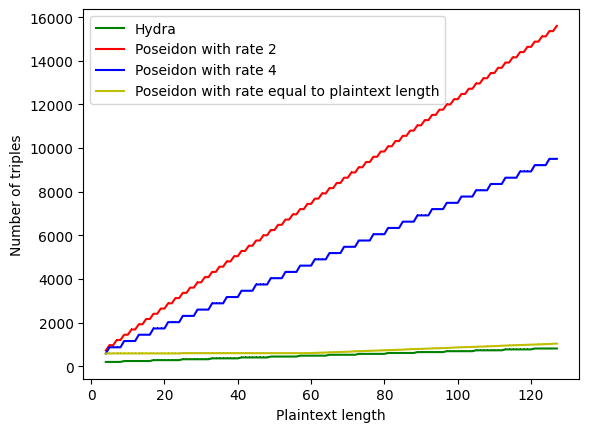

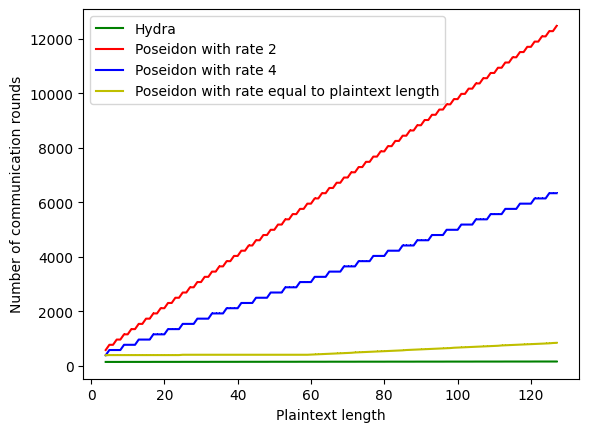

In [136]:
mpc_dict_encryption = {"Algorithm": [], "Output length": [], "Number of triples": [], "Number of communication rounds": []}

ts = range(4,128)
for t in ts:#[4,8,16,32,64,128]:
    for r in [2,4]:
        mpc_dict_encryption["Algorithm"].append(f"Poseidon with rate {r}")
        mpc_dict_encryption["Output length"].append(t)
        mpc_dict_encryption["Number of triples"].append(f(t,t,r)[3])
        mpc_dict_encryption["Number of communication rounds"].append(f(t,t,r)[2])
    
    mpc_dict_encryption["Algorithm"].append(f"Hydra")
    mpc_dict_encryption["Output length"].append(t)
    mpc_dict_encryption["Number of triples"].append(g(t)[0])
    mpc_dict_encryption["Number of communication rounds"].append(g(t)[1])

df = pd.DataFrame(mpc_dict_encryption)

print(df[df["Output length"].isin(std_os)]
      .set_index(["Output length", "Algorithm"])
      .to_latex(caption="Number of multiplication triples and communication rounds for computation of ciphertext in Hydra and Poseidon in MPC (excluding the final opening)"))


hydra_cols = df[df["Algorithm"]=="Hydra"]
pos2_cols = df[df["Algorithm"]=="Poseidon with rate 2"]
pos4_cols = df[df["Algorithm"]=="Poseidon with rate 4"]

for i in ["triples", "communication rounds"]:
    plt.plot(hydra_cols["Output length"], hydra_cols[f"Number of {i}"],"g,-", label="Hydra")
    plt.plot(pos2_cols["Output length"], pos2_cols[f"Number of {i}"], "r,-",label="Poseidon with rate 2")
    plt.plot(pos4_cols["Output length"], pos4_cols[f"Number of {i}"], "b,-",label="Poseidon with rate 4")
    if i == "triples":
        plt.plot(ts, [f_rate(4,o)[3] for o in ts],"y,-", label="Poseidon with rate equal to plaintext length")
    else:
        plt.plot(ts, [f_rate(4,o)[2] for o in ts], "y,-", label="Poseidon with rate equal to plaintext length")

    plt.xlabel("Plaintext length")
    plt.ylabel(f"Number of {i}")
    title = f"MPC efficiency of encrypting in terms of number of {i}"
    #plt.title(wrap(title, 65))
    plt.legend()
    plt.savefig(imgs_path+title+".png")
    plt.show()

In [137]:
"""df1 = pd.read_csv("run-bench-13-08-24.csv")#benchmark.csv")#
df2 = pd.read_csv("run-bench-14-08-24.csv")#benchmark.csv")#
df3 = pd.read_csv("benchmark.csv")
df3 = df3[(df3["program"] == "hydra-hash") | (df3["program"] == "hydra-encrypt")]
df4 = pd.read_csv("run-bench-14-08-24-2.csv")#benchmark.csv")#

df1[df1["input_len"] == 4][["program", "output_len", "parties", "rate", "party 0 runtime", "party 1 runtime", "party 0 data", "party 1 data", "party 0 cpu time", "party 1 cpu time", "global data"]]
"""

'df1 = pd.read_csv("run-bench-13-08-24.csv")#benchmark.csv")#\ndf2 = pd.read_csv("run-bench-14-08-24.csv")#benchmark.csv")#\ndf3 = pd.read_csv("benchmark.csv")\ndf3 = df3[(df3["program"] == "hydra-hash") | (df3["program"] == "hydra-encrypt")]\ndf4 = pd.read_csv("run-bench-14-08-24-2.csv")#benchmark.csv")#\n\ndf1[df1["input_len"] == 4][["program", "output_len", "parties", "rate", "party 0 runtime", "party 1 runtime", "party 0 data", "party 1 data", "party 0 cpu time", "party 1 cpu time", "global data"]]\n'

In [138]:
#df = pd.concat([df1, df2, df3, df4])
df = pd.read_csv("result_file.csv")

def getValue(input_len, output_len, program, rate, parties, label):
    res = df[(df["input_len"] == input_len) & (df["output_len"] == output_len) & (df["program"] == program) 
        & (df["rate"] == rate) & (df["parties"] == parties)][label].values
    if len(res) > 0:
        if len(res) > 1:
            #print(df[(df["input_len"] == input_len) & (df["output_len"] == output_len) & (df["program"] == program) 
        #& (df["rate"] == rate) & (df["parties"] == parties)])
            print(len(res))
        
        return res[0]
    print("No value for", input_len, output_len, program, rate, parties, label)
    
def getValueHydra(input_len, output_len, program, parties, label):
    res = df[(df["input_len"] == input_len) & (df["output_len"] == output_len) & (df["program"] == program) 
        &  (df["parties"] == parties)][label].values
    if len(res) > 0:
        if len(res) > 1:
            #print(df[(df["input_len"] == input_len) & (df["output_len"] == output_len) & (df["program"] == program) 
        #& (df["rate"] == rate) & (df["parties"] == parties)])
            print(len(res))
        
        return res[0]
    print("No value for hdyra, ", input_len, output_len, program, parties, label)


In [139]:
#df = pd.concat([df1, df2, df3, df4])
df = pd.read_csv("result_file.csv")
mpc_dict = {"Algorithm": [], "Output length": [], "Number of triples": [], "Number of communication rounds": [], "Rate":[],
            "Average running time of a party (seconds)": [], "Average CPU time of a party (seconds)": [], "Global data (MB)": [], "Number of parties": []}

for n in [4]:
    for o in [4,8, 16,32,64]:
        for parties in [2,3,5,10,15]:
            for r in [2,4]:
                if getValue(n, o, "poseidon-2-0-hash", r, parties, "party 0 runtime") is None:
                    continue
                mpc_dict["Algorithm"].append(f"Poseidon")
                mpc_dict["Rate"].append(r)
                mpc_dict["Output length"].append(o)
                mpc_dict["Number of triples"].append(f(n,o,r)[0])
                mpc_dict["Number of communication rounds"].append(f(n,o,r)[1])
                mpc_dict["Average running time of a party (seconds)"].append(getValue(n, o, "poseidon-2-0-hash", r, parties, "party 0 runtime"))
                mpc_dict["Average CPU time of a party (seconds)"].append(getValue(n, o, "poseidon-2-0-hash", r, parties, "party 0 cpu time"))
                mpc_dict["Global data (MB)"].append(getValue(n, o, "poseidon-2-0-hash", r, parties, "global data"))
                mpc_dict["Number of parties"].append(parties)
        

            if  getValueHydra(n, o, "hydra-hash",  parties, "party 0 runtime") is None: 
                continue
            mpc_dict["Algorithm"].append(f"Hydra")
            mpc_dict["Output length"].append(o)
            mpc_dict["Rate"].append(None)
            mpc_dict["Number of triples"].append(g(o)[0])
            mpc_dict["Number of communication rounds"].append(g(o)[1])
            print(n, o, "hydra-hash", r, parties, "party 0 runtime", getValueHydra(n, o, "hydra-hash",  parties, "party 0 runtime"))
            mpc_dict["Average running time of a party (seconds)"].append(getValueHydra(n, o, "hydra-hash", parties, "party 0 runtime"))
            mpc_dict["Average CPU time of a party (seconds)"].append(getValueHydra(n, o, "hydra-hash", parties, "party 0 cpu time"))
            mpc_dict["Global data (MB)"].append(getValueHydra(n, o, "hydra-hash",  parties, "global data"))
            mpc_dict["Number of parties"].append(parties)

df = pd.DataFrame(mpc_dict).drop(columns=["Number of triples", "Number of communication rounds"])
df = df.set_index(["Output length", "Number of parties", "Algorithm"])
#print(df.columns)
#print(df)
print(df.to_latex(caption="Number of multiplication triples and communication rounds for hash using Hydra and Poseidon in MPC (excluding the final opening) together with average of 20 runs for running and CPU times of a party in seconds and amount of total data communicated in MB.",
    float_format="%.2f"))

4 4 hydra-hash 4 2 party 0 runtime 0.3423229
4 4 hydra-hash 4 3 party 0 runtime 0.54278955
4 4 hydra-hash 4 5 party 0 runtime 1.3626725
4 4 hydra-hash 4 10 party 0 runtime 4.6709285000000005
4 4 hydra-hash 4 15 party 0 runtime 11.460805
4 8 hydra-hash 4 2 party 0 runtime 0.3324199499999999
4 8 hydra-hash 4 3 party 0 runtime 0.48956985
4 8 hydra-hash 4 5 party 0 runtime 1.6842685
4 8 hydra-hash 4 10 party 0 runtime 4.712257500000001
4 8 hydra-hash 4 15 party 0 runtime 11.184325
4 16 hydra-hash 4 2 party 0 runtime 0.4093378
4 16 hydra-hash 4 3 party 0 runtime 0.5718033000000001
4 16 hydra-hash 4 5 party 0 runtime 1.6037719999999998
4 16 hydra-hash 4 10 party 0 runtime 5.584658
4 16 hydra-hash 4 15 party 0 runtime 13.412325
4 32 hydra-hash 4 2 party 0 runtime 0.54962455
No value for 4 32 poseidon-2-0-hash 2 3 party 0 runtime
No value for 4 32 poseidon-2-0-hash 4 3 party 0 runtime
No value for hdyra,  4 32 hydra-hash 3 party 0 runtime
No value for 4 32 poseidon-2-0-hash 2 5 party 0 runtime

In [140]:
df = pd.read_csv("result_file.csv")
df[df["program"] == "hydra-hash"]

,program,using squares,squares,integer triples,vm rounds,rate,input_len,output_len,parties,global data,...,party 10 cpu time,party 11 cpu time,party 12 cpu time,party 13 cpu time,party 14 cpu time,party 15 cpu time,party 16 cpu time,party 17 cpu time,party 18 cpu time,party 19 cpu time
6,hydra-hash,0,NaN,193,140,NaN,4,4,2,27.6513,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,hydra-hash,0,NaN,193,140,NaN,4,8,2,27.6519,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,hydra-hash,0,NaN,234,141,NaN,4,16,2,33.5167,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,hydra-hash,0,NaN,316,143,NaN,4,32,2,45.2470,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,hydra-hash,0,NaN,480,147,NaN,4,64,2,68.7076,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,hydra-hash,0,NaN,193,140,NaN,4,4,3,82.9167,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,hydra-hash,0,NaN,193,140,NaN,4,8,3,82.9180,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49,hydra-hash,0,NaN,234,141,NaN,4,16,3,100.5040,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54,hydra-hash,0,NaN,193,140,NaN,4,4,5,276.2900,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59,hydra-hash,0,NaN,193,140,NaN,4,8,5,276.2930,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


4 4 hydra-hash 4 2 party 0 runtime 0.3423229
4 4 hydra-hash 4 3 party 0 runtime 0.54278955
4 4 hydra-hash 4 5 party 0 runtime 1.3626725
4 4 hydra-hash 4 10 party 0 runtime 4.6709285000000005
4 4 hydra-hash 4 15 party 0 runtime 11.460805
4 8 hydra-hash 4 2 party 0 runtime 0.3324199499999999
4 8 hydra-hash 4 3 party 0 runtime 0.48956985
4 8 hydra-hash 4 5 party 0 runtime 1.6842685
4 8 hydra-hash 4 10 party 0 runtime 4.712257500000001
4 8 hydra-hash 4 15 party 0 runtime 11.184325
4 16 hydra-hash 4 2 party 0 runtime 0.4093378
4 16 hydra-hash 4 3 party 0 runtime 0.5718033000000001
4 16 hydra-hash 4 5 party 0 runtime 1.6037719999999998
4 16 hydra-hash 4 10 party 0 runtime 5.584658
4 16 hydra-hash 4 15 party 0 runtime 13.412325
4 32 hydra-hash 4 2 party 0 runtime 0.54962455
No value for 4 32 poseidon-2-0-hash 2 3 party 0 runtime
No value for 4 32 poseidon-2-0-hash 4 3 party 0 runtime
No value for hdyra,  4 32 hydra-hash 3 party 0 runtime
No value for 4 32 poseidon-2-0-hash 2 5 party 0 runtime

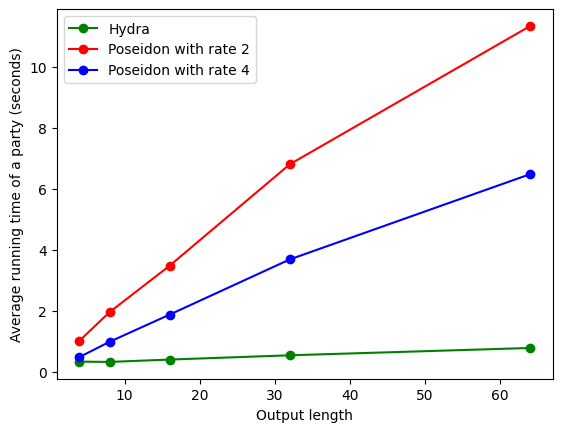

    Output length  Number of parties             Algorithm  \
0               4                  2  Poseidon with rate 2   
15              8                  2  Poseidon with rate 2   
30             16                  2  Poseidon with rate 2   
45             32                  2  Poseidon with rate 2   
48             64                  2  Poseidon with rate 2   

    Average running time of a party (seconds)  \
0                                    1.026204   
15                                   1.961488   
30                                   3.484424   
45                                   6.808475   
48                                  11.338705   

    Average CPU time of a party (seconds)  Global data (MB)  
0                                0.703557           103.033  
15                               1.263389           171.713  
30                               2.260552           309.052  
45                               4.537898           583.729  
48                    

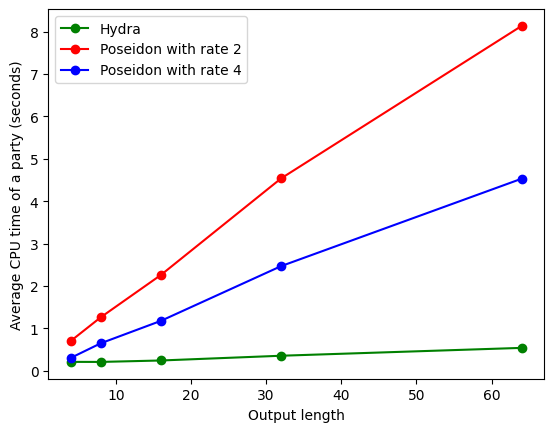

    Output length  Number of parties             Algorithm  \
0               4                  2  Poseidon with rate 2   
15              8                  2  Poseidon with rate 2   
30             16                  2  Poseidon with rate 2   
45             32                  2  Poseidon with rate 2   
48             64                  2  Poseidon with rate 2   

    Average running time of a party (seconds)  \
0                                    1.026204   
15                                   1.961488   
30                                   3.484424   
45                                   6.808475   
48                                  11.338705   

    Average CPU time of a party (seconds)  Global data (MB)  
0                                0.703557           103.033  
15                               1.263389           171.713  
30                               2.260552           309.052  
45                               4.537898           583.729  
48                    

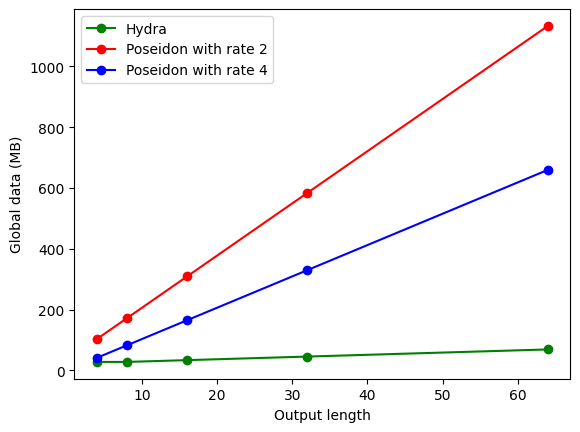

    Output length  Number of parties             Algorithm  \
0               4                  2  Poseidon with rate 2   
15              8                  2  Poseidon with rate 2   
30             16                  2  Poseidon with rate 2   
45             32                  2  Poseidon with rate 2   
48             64                  2  Poseidon with rate 2   

    Average running time of a party (seconds)  \
0                                    1.026204   
15                                   1.961488   
30                                   3.484424   
45                                   6.808475   
48                                  11.338705   

    Average CPU time of a party (seconds)  Global data (MB)  
0                                0.703557           103.033  
15                               1.263389           171.713  
30                               2.260552           309.052  
45                               4.537898           583.729  
48                    

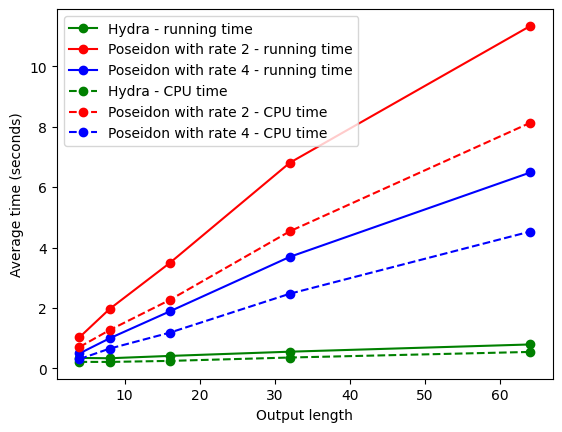

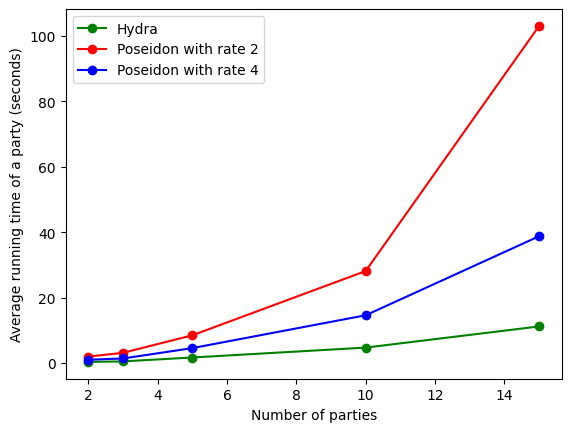

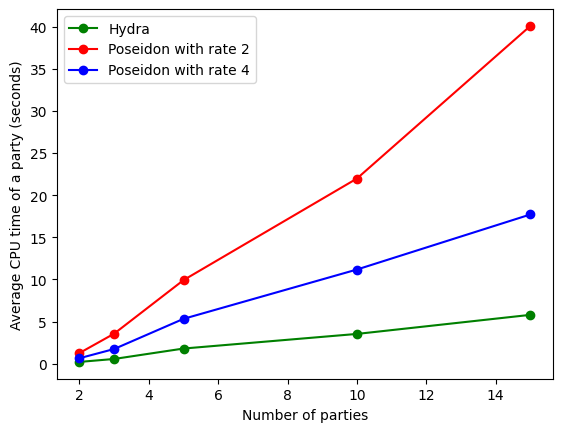

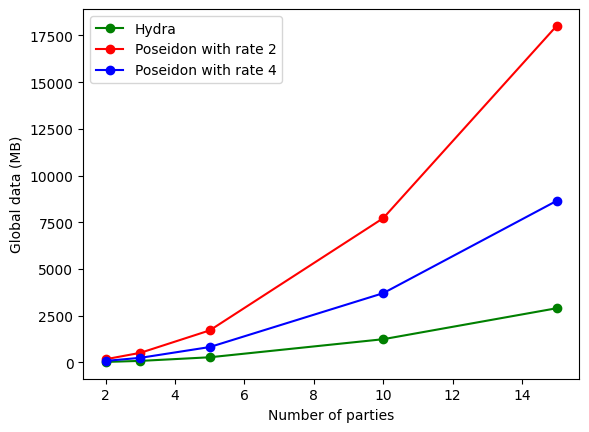

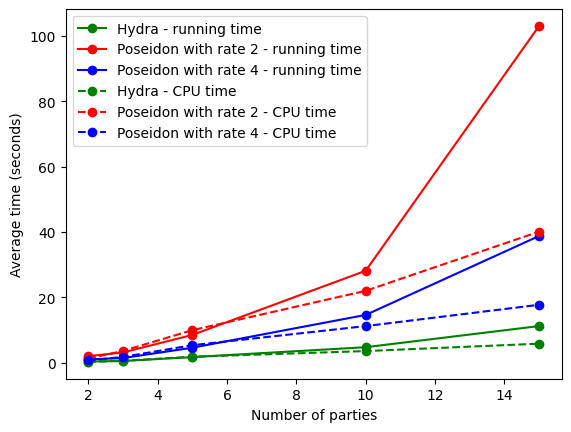

In [141]:
#df = pd.concat([df1, df2, df3, df4])
df = pd.read_csv("result_file.csv")
mpc_dict = {"Algorithm": [], "Output length": [], "Number of triples": [], "Number of communication rounds": [], 
            "Average running time of a party (seconds)": [], "Average CPU time of a party (seconds)": [], "Global data (MB)": [], "Number of parties": []}

for n in [4]:
    for o in [4,8, 16,32,64]:
        for parties in [2,3,5,10,15]:
            for r in [2,4]:
                if getValue(n, o, "poseidon-2-0-hash", r, parties, "party 0 runtime") is None:
                    continue
                mpc_dict["Algorithm"].append(f"Poseidon with rate {r}")
                mpc_dict["Output length"].append(o)
                mpc_dict["Number of triples"].append(f(n,o,r)[0])
                mpc_dict["Number of communication rounds"].append(f(n,o,r)[1])
                mpc_dict["Average running time of a party (seconds)"].append(getValue(n, o, "poseidon-2-0-hash", r, parties, "party 0 runtime"))
                mpc_dict["Average CPU time of a party (seconds)"].append(getValue(n, o, "poseidon-2-0-hash", r, parties, "party 0 cpu time"))
                mpc_dict["Global data (MB)"].append(getValue(n, o, "poseidon-2-0-hash", r, parties, "global data"))
                mpc_dict["Number of parties"].append(parties)
        

            if  getValueHydra(n, o, "hydra-hash",  parties, "party 0 runtime") is None: 
                continue
            mpc_dict["Algorithm"].append(f"Hydra")
            mpc_dict["Output length"].append(o)
            mpc_dict["Number of triples"].append(g(o)[0])
            mpc_dict["Number of communication rounds"].append(g(o)[1])
            print(n, o, "hydra-hash", r, parties, "party 0 runtime", getValueHydra(n, o, "hydra-hash",  parties, "party 0 runtime"))
            mpc_dict["Average running time of a party (seconds)"].append(getValueHydra(n, o, "hydra-hash", parties, "party 0 runtime"))
            mpc_dict["Average CPU time of a party (seconds)"].append(getValueHydra(n, o, "hydra-hash", parties, "party 0 cpu time"))
            mpc_dict["Global data (MB)"].append(getValueHydra(n, o, "hydra-hash",  parties, "global data"))
            mpc_dict["Number of parties"].append(parties)

df = pd.DataFrame(mpc_dict)
print(df[df["Algorithm"] == "Hydra"][["Output length", "Number of triples", "Number of communication rounds"]])
df= df.drop(columns=["Number of triples", "Number of communication rounds"])
df = df.set_index(["Output length", "Number of parties", "Algorithm"])
print(df.to_latex(caption="Number of multiplication triples and communication rounds for hash using Hydra and Poseidon in MPC (excluding the final opening) together with average of 20 runs for running and CPU times of a party in seconds and amount of total data communicated in MB.",
    float_format="%.2f"))


df = df.reset_index()


for i in ["Average running time of a party (seconds)","Average CPU time of a party (seconds)","Global data (MB)"]:
    for p in [2]:
        hydra_cols = df[(df["Algorithm"]=="Hydra") & (df["Number of parties"] == p)]
        pos2_cols = df[(df["Algorithm"]=="Poseidon with rate 2") & (df["Number of parties"] == p)]
        print(pos2_cols)
        pos4_cols = df[(df["Algorithm"]=="Poseidon with rate 4") & (df["Number of parties"] == p)]

        plt.plot(hydra_cols["Output length"], hydra_cols[i], "go-", label=f"Hydra")
        plt.plot(pos2_cols["Output length"], pos2_cols[i],"ro-",label=f"Poseidon with rate 2")
        plt.plot(pos4_cols["Output length"], pos4_cols[i],"bo-", label=f"Poseidon with rate 4")

        #plt.plot(range(128), [f(4,o,max(o,1))[1] for o in range(128)], label=f"Poseidon with rate equal to plaintext length {p} parties")

        plt.xlabel("Output length")
        plt.ylabel(f"{i}")
        title = f"MPC efficiency of hashing 4 words in terms of {i} for 2 parties (average of 20 runs)"
        #plt.title(wrap(title, 65))
        plt.legend()
        plt.savefig(imgs_path+title+".png")
        plt.show()

#joint plot for running times
for p in [2]:
    hydra_cols = df[(df["Algorithm"]=="Hydra") & (df["Number of parties"] == p)]
    pos2_cols = df[(df["Algorithm"]=="Poseidon with rate 2") & (df["Number of parties"] == p)]
    print(pos2_cols)
    pos4_cols = df[(df["Algorithm"]=="Poseidon with rate 4") & (df["Number of parties"] == p)]

    running_time = "Average running time of a party (seconds)"
    cpu_time = "Average CPU time of a party (seconds)"
    plt.plot(hydra_cols["Output length"], hydra_cols[running_time], "go-", label=f"Hydra - running time")
    plt.plot(pos2_cols["Output length"], pos2_cols[running_time],"ro-", label=f"Poseidon with rate 2 - running time")
    plt.plot(pos4_cols["Output length"], pos4_cols[running_time],"bo-", label=f"Poseidon with rate 4 - running time")

    plt.plot(hydra_cols["Output length"], hydra_cols[cpu_time], "go--", label=f"Hydra - CPU time")
    plt.plot(pos2_cols["Output length"], pos2_cols[cpu_time], "ro--",label=f"Poseidon with rate 2 - CPU time")
    plt.plot(pos4_cols["Output length"], pos4_cols[cpu_time],"bo--", label=f"Poseidon with rate 4 - CPU time")
    #plt.plot(range(128), [f(4,o,max(o,1))[1] for o in range(128)], label=f"Poseidon with rate equal to plaintext length {p} parties")

    plt.xlabel("Output length")
    plt.ylabel("Average time (seconds)")
    title = f"MPC efficiency of hashing 4 words in terms of running times for 2 parties (average of 20 runs)"
    #plt.title(wrap(title, 65))
    plt.legend()
    plt.savefig(imgs_path+title+".png")
    plt.show()

for i in ["Average running time of a party (seconds)","Average CPU time of a party (seconds)","Global data (MB)"]:
    hydra_cols = df[(df["Algorithm"]=="Hydra") & (df["Output length"]==8)]
    pos2_cols = df[(df["Algorithm"]=="Poseidon with rate 2")& (df["Output length"]==8)]
    pos4_cols = df[(df["Algorithm"]=="Poseidon with rate 4")& (df["Output length"]==8)]

    plt.plot(hydra_cols["Number of parties"], hydra_cols[i],"go-", label=f"Hydra")
    plt.plot(pos2_cols["Number of parties"], pos2_cols[i],"ro-",label=f"Poseidon with rate 2")
    plt.plot(pos4_cols["Number of parties"], pos4_cols[i], "bo-", label=f"Poseidon with rate 4")

    #plt.plot(range(128), [f(4,o,max(o,1))[1] for o in range(128)], label=f"Poseidon with rate equal to plaintext length {p} parties")

    plt.xlabel("Number of parties")
    plt.ylabel(f"{i}")
    title = f"MPC efficiency of hashing 4 words to 8 words in terms of {i} (average of 20 runs)"
    #plt.title(wrap(title, 65))
    plt.legend()
    plt.savefig(imgs_path+title+".png", bbox_inches='tight')
    plt.show()

#joint plot for running times
for p in [2]:
    hydra_cols = df[(df["Algorithm"]=="Hydra") & (df["Output length"]==8)]
    pos2_cols = df[(df["Algorithm"]=="Poseidon with rate 2") & (df["Output length"]==8)]
    pos4_cols = df[(df["Algorithm"]=="Poseidon with rate 4") & (df["Output length"]==8)]

    running_time = "Average running time of a party (seconds)"
    cpu_time = "Average CPU time of a party (seconds)"
    plt.plot(hydra_cols["Number of parties"], hydra_cols[running_time], "go-", label=f"Hydra - running time")
    plt.plot(pos2_cols["Number of parties"], pos2_cols[running_time],"ro-", label=f"Poseidon with rate 2 - running time")
    plt.plot(pos4_cols["Number of parties"], pos4_cols[running_time],"bo-", label=f"Poseidon with rate 4 - running time")

    plt.plot(hydra_cols["Number of parties"], hydra_cols[cpu_time], "go--", label=f"Hydra - CPU time")
    plt.plot(pos2_cols["Number of parties"], pos2_cols[cpu_time], "ro--",label=f"Poseidon with rate 2 - CPU time")
    plt.plot(pos4_cols["Number of parties"], pos4_cols[cpu_time],"bo--", label=f"Poseidon with rate 4 - CPU time")
    #plt.plot(range(128), [f(4,o,max(o,1))[1] for o in range(128)], label=f"Poseidon with rate equal to plaintext length {p} parties")

    plt.xlabel("Number of parties")
    plt.ylabel("Average time (seconds)")
    title = f"MPC efficiency of hashing 4 words to 8 words in terms of running times (average of 20 runs)"
    #plt.title(wrap(title, 65))
    plt.legend()
    plt.savefig(imgs_path+title+".png")
    plt.show()

4 4 hydra-hash 2 2 party 0 runtime 0.29269775
4 4 hydra-hash 2 3 party 0 runtime 0.53411355
4 4 hydra-hash 2 5 party 0 runtime 1.4451205
4 4 hydra-hash 2 10 party 0 runtime 4.7030665
4 4 hydra-hash 2 15 party 0 runtime 11.15674
8 8 hydra-hash 2 2 party 0 runtime 0.3192207999999999
8 8 hydra-hash 2 3 party 0 runtime 0.5131896
8 8 hydra-hash 2 5 party 0 runtime 1.642621
8 8 hydra-hash 2 10 party 0 runtime 4.745520000000001
8 8 hydra-hash 2 15 party 0 runtime 11.200949999999995
16 16 hydra-hash 2 2 party 0 runtime 0.4058328
16 16 hydra-hash 2 3 party 0 runtime 0.5833212
16 16 hydra-hash 2 5 party 0 runtime 1.5248199999999998
16 16 hydra-hash 2 10 party 0 runtime 5.6416984999999995
16 16 hydra-hash 2 15 party 0 runtime 13.515569999999997
32 32 hydra-hash 2 2 party 0 runtime 0.5298619
No value for 32 32 poseidon-2-0-encrypt 2 3 party 0 runtime
No value for 32 32 poseidon-2-0-encrypt 2 5 party 0 runtime
No value for 32 32 poseidon-2-0-encrypt 2 10 party 0 runtime
No value for 32 32 poseidon-

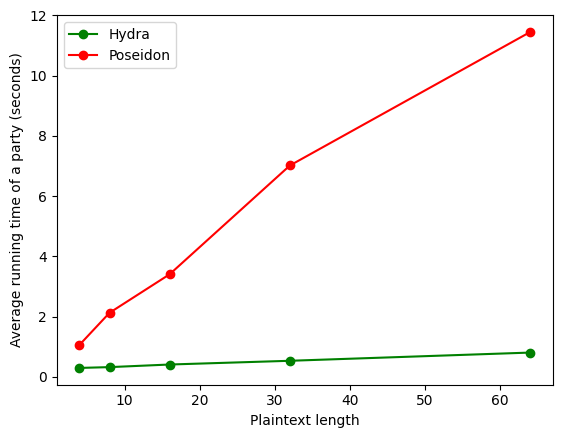

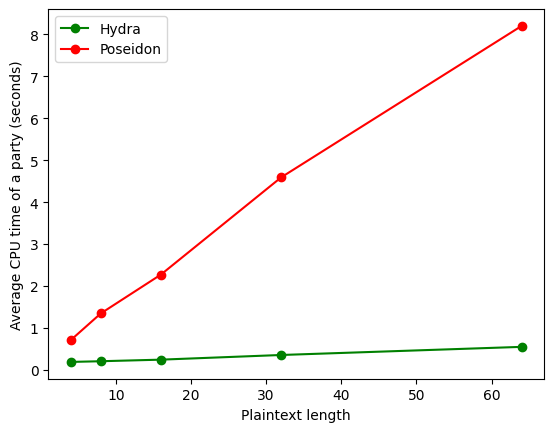

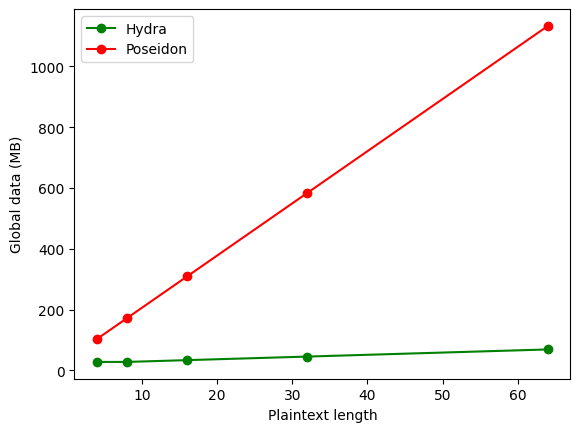

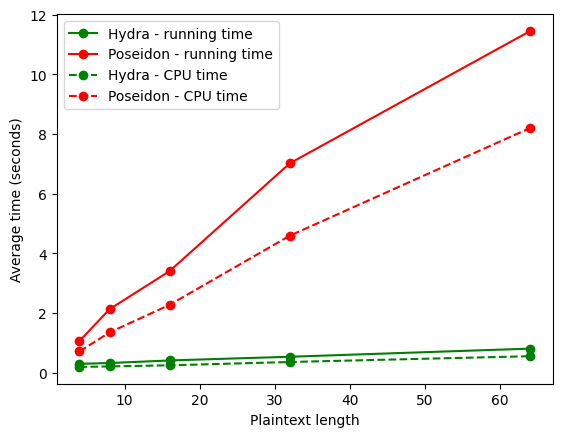

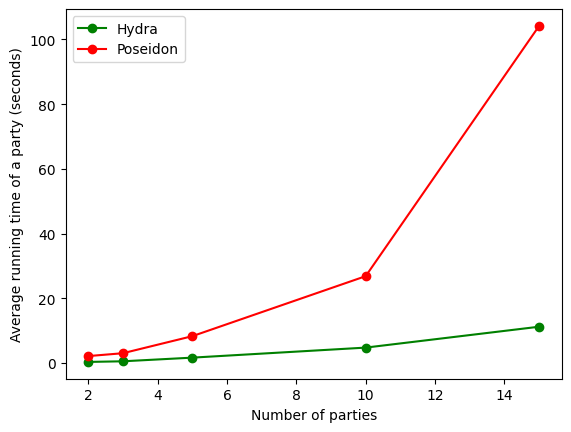

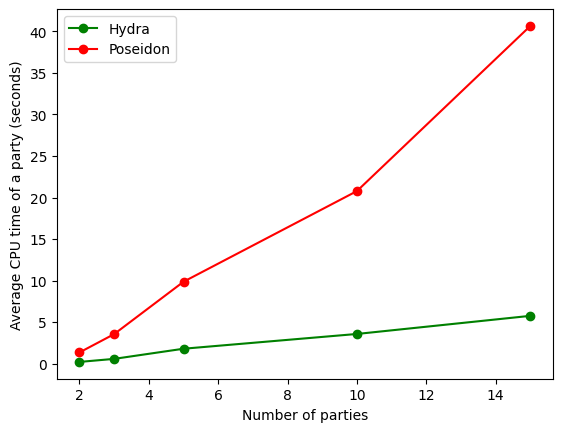

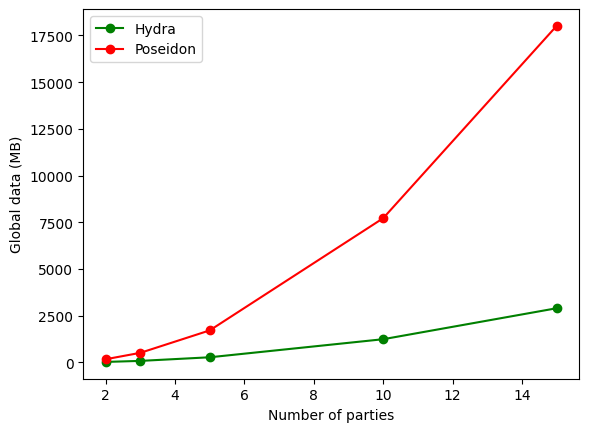

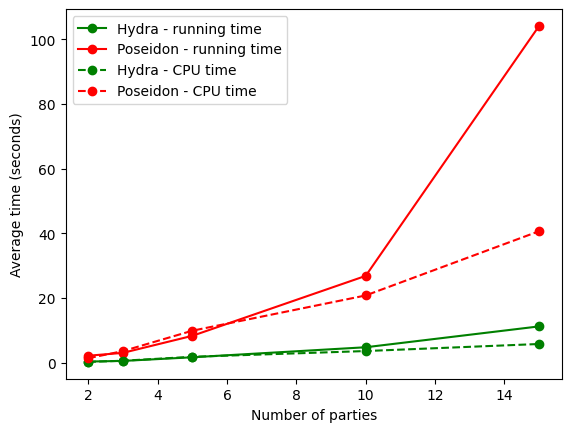

In [143]:
#df = pd.concat([df1, df2, df3, df4])
df = pd.read_csv("result_file.csv")

mpc_dict = {"Algorithm": [], "Output length": [], "Number of triples": [], "Number of communication rounds": [], 
            "Average running time of a party (seconds)": [], "Average CPU time of a party (seconds)": [], "Global data (MB)": [], "Number of parties": []}

#encrypt r is just 2
r = 2
for o in [4,8, 16, 32, 64]:
    for n in [o]:
        for parties in [2,3,5,10, 15]:
            if getValue(n, o, "poseidon-2-0-encrypt", r, parties, "party 0 runtime") is None:
                continue
            mpc_dict["Algorithm"].append(f"Poseidon")
            mpc_dict["Output length"].append(o)
            mpc_dict["Number of triples"].append(f(n,o,r)[3])
            mpc_dict["Number of communication rounds"].append(f(n,o,r)[2])
            mpc_dict["Average running time of a party (seconds)"].append(getValue(n, o, "poseidon-2-0-encrypt", r, parties, "party 0 runtime"))
            mpc_dict["Average CPU time of a party (seconds)"].append(getValue(n, o, "poseidon-2-0-encrypt", r, parties, "party 0 cpu time"))
            mpc_dict["Global data (MB)"].append(getValue(n, o, "poseidon-2-0-encrypt", r, parties, "global data"))
            mpc_dict["Number of parties"].append(parties)
        


            mpc_dict["Algorithm"].append(f"Hydra")
            mpc_dict["Output length"].append(o)
            mpc_dict["Number of triples"].append(g(o)[0])
            mpc_dict["Number of communication rounds"].append(g(o)[1])
            print(n, o, "hydra-hash", r, parties, "party 0 runtime", getValueHydra(n, o, "hydra-encrypt",  parties, "party 0 runtime"))
            mpc_dict["Average running time of a party (seconds)"].append(getValueHydra(n, o, "hydra-encrypt", parties, "party 0 runtime"))
            mpc_dict["Average CPU time of a party (seconds)"].append(getValueHydra(n, o, "hydra-encrypt", parties, "party 0 cpu time"))
            mpc_dict["Global data (MB)"].append(getValueHydra(n, o, "hydra-encrypt",  parties, "global data"))
            mpc_dict["Number of parties"].append(parties)

df = pd.DataFrame(mpc_dict).drop(columns=["Number of triples", "Number of communication rounds"])
df = df.set_index(["Output length", "Number of parties", "Algorithm"])
print(df.to_latex(caption="Number of multiplication triples and communication rounds for computation of encrypting using Hydra and Poseidon in MPC (excluding the final opening) together with average of 20 runs for running and CPU times of a party in seconds and amount of total data communicated in MB.",
                  float_format="%.2f"))


df = df.reset_index()


for i in ["Average running time of a party (seconds)","Average CPU time of a party (seconds)","Global data (MB)"]:
    for p in [2]:
        hydra_cols = df[(df["Algorithm"]=="Hydra") & (df["Number of parties"] == p)]
        pos_cols = df[(df["Algorithm"]=="Poseidon") & (df["Number of parties"] == p)]

        plt.plot(hydra_cols["Output length"], hydra_cols[i],"go-", label=f"Hydra")
        plt.plot(pos_cols["Output length"], pos_cols[i],"ro-", label=f"Poseidon")

        #plt.plot(range(128), [f(4,o,max(o,1))[1] for o in range(128)], label=f"Poseidon with rate equal to plaintext length {p} parties")

        plt.xlabel("Plaintext length")
        plt.ylabel(f"{i}")
        title = f"MPC efficiency of encrypting in terms of {i} for 2 parties (average of 20 runs)"
        #plt.title(wrap(title, 65))
        plt.legend()
        plt.savefig(imgs_path+title+".png")
        plt.show()

#joint plot for running times
for p in [2]:
    hydra_cols = df[(df["Algorithm"]=="Hydra") & (df["Number of parties"] == p)]
    pos_cols = df[(df["Algorithm"]=="Poseidon") & (df["Number of parties"] == p)]

    running_time = "Average running time of a party (seconds)"
    cpu_time = "Average CPU time of a party (seconds)"
    plt.plot(hydra_cols["Output length"], hydra_cols[running_time],"go-", label=f"Hydra - running time")
    plt.plot(pos_cols["Output length"], pos_cols[running_time],"ro-", label=f"Poseidon - running time")

    plt.plot(hydra_cols["Output length"], hydra_cols[cpu_time],"go--", label=f"Hydra - CPU time")
    plt.plot(pos_cols["Output length"], pos_cols[cpu_time],"ro--", label=f"Poseidon - CPU time")

    plt.xlabel("Plaintext length")
    plt.ylabel("Average time (seconds)")
    title = f"MPC efficiency of encrypting in terms of running times for 2 parties (average of 20 runs)"
    #plt.title(wrap(title, 65))
    plt.legend()
    plt.savefig(imgs_path+title+".png")
    plt.show()

for i in ["Average running time of a party (seconds)","Average CPU time of a party (seconds)","Global data (MB)"]:
    hydra_cols = df[(df["Algorithm"]=="Hydra") & (df["Output length"]==8)]
    pos_cols = df[(df["Algorithm"]=="Poseidon")& (df["Output length"]==8)]

    plt.plot(hydra_cols["Number of parties"], hydra_cols[i],"go-", label=f"Hydra")
    plt.plot(pos_cols["Number of parties"], pos_cols[i],"ro-", label=f"Poseidon")
    #plt.plot(range(128), [f(4,o,max(o,1))[1] for o in range(128)], label=f"Poseidon with rate equal to plaintext length {p} parties")

    plt.xlabel("Number of parties")
    plt.ylabel(f"{i}")
    title = f"MPC efficiency of encrypting 8 words in terms of {i} (average of 20 runs)"
    #plt.title(wrap(title, 65))
    plt.legend()
    plt.savefig(imgs_path+title+".png")
    plt.show()

#joint plot for running times
hydra_cols = df[(df["Algorithm"]=="Hydra")  & (df["Output length"]==8)]
pos_cols = df[(df["Algorithm"]=="Poseidon") & (df["Output length"]==8)]

running_time = "Average running time of a party (seconds)"
cpu_time = "Average CPU time of a party (seconds)"
plt.plot(hydra_cols["Number of parties"], hydra_cols[running_time],"go-", label=f"Hydra - running time")
plt.plot(pos_cols["Number of parties"], pos_cols[running_time],"ro-", label=f"Poseidon - running time")

plt.plot(hydra_cols["Number of parties"], hydra_cols[cpu_time],"go--", label=f"Hydra - CPU time")
plt.plot(pos_cols["Number of parties"], pos_cols[cpu_time],"ro--", label=f"Poseidon - CPU time")

plt.xlabel("Number of parties")
plt.ylabel("Average time (seconds)")
title = f"MPC efficiency of encrypting 8 words in terms of running times (average of 20 runs)"
#plt.title(wrap(title, 65))
plt.legend()
plt.savefig(imgs_path+title+".png")
plt.show()

In [144]:
print(df.to_latex())

\begin{tabular}{lrrlrrr}
\toprule
 & Output length & Number of parties & Algorithm & Average running time of a party (seconds) & Average CPU time of a party (seconds) & Global data (MB) \\
\midrule
0 & 4 & 2 & Poseidon & 1.056798 & 0.707514 & 103.034000 \\
1 & 4 & 2 & Hydra & 0.292698 & 0.188979 & 27.651300 \\
2 & 4 & 3 & Poseidon & 1.701227 & 2.154708 & 308.962000 \\
3 & 4 & 3 & Hydra & 0.534114 & 0.602834 & 82.916700 \\
4 & 4 & 5 & Poseidon & 5.007453 & 6.103432 & 1029.510000 \\
5 & 4 & 5 & Hydra & 1.445121 & 1.673619 & 276.290000 \\
6 & 4 & 10 & Poseidon & 24.722365 & 15.180295 & 4631.530000 \\
7 & 4 & 10 & Hydra & 4.703067 & 3.554741 & 1242.970000 \\
8 & 4 & 15 & Poseidon & 50.145630 & 22.462995 & 10805.900000 \\
9 & 4 & 15 & Hydra & 11.156740 & 5.785503 & 2900.000000 \\
10 & 8 & 2 & Poseidon & 2.123056 & 1.344775 & 171.713000 \\
11 & 8 & 2 & Hydra & 0.319221 & 0.205419 & 27.651900 \\
12 & 8 & 3 & Poseidon & 3.009169 & 3.552332 & 514.908000 \\
13 & 8 & 3 & Hydra & 0.513190 & 0.5722

In [145]:
df = pd.read_csv("result_file.csv")
df[df["program"]=="poseidon-2-0-hash"]

,program,using squares,squares,integer triples,vm rounds,rate,input_len,output_len,parties,global data,...,party 10 cpu time,party 11 cpu time,party 12 cpu time,party 13 cpu time,party 14 cpu time,party 15 cpu time,party 16 cpu time,party 17 cpu time,party 18 cpu time,party 19 cpu time
1,poseidon-2-0-hash,0,NaN,720,577,2.0,4,4,2,103.0330,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,poseidon-2-0-hash,0,NaN,1200,961,2.0,8,4,2,171.7130,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,poseidon-2-0-hash,0,NaN,288,193,4.0,4,4,2,41.2401,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,poseidon-2-0-hash,0,NaN,576,385,4.0,8,4,2,82.4357,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,poseidon-2-0-hash,0,NaN,1200,961,2.0,4,8,2,171.7130,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,poseidon-2-0-hash,0,NaN,1680,1345,2.0,8,8,2,240.3720,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,poseidon-2-0-hash,0,NaN,576,385,4.0,4,8,2,82.4362,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,poseidon-2-0-hash,0,NaN,864,577,4.0,8,8,2,123.6320,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,poseidon-2-0-hash,0,NaN,2160,1729,2.0,4,16,2,309.0520,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,poseidon-2-0-hash,0,NaN,2640,2113,2.0,8,16,2,377.7110,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [146]:
#df = pd.read_csv("result_file.csv")
#df[df["program"]=="poseidon-2-0-hash"]

Up to feasible benchmarks

In [147]:
df = pd.read_csv("results-up-to-feasible.csv")
df_org = df[["program", "global data", "input_len", "output_len", "parties","party 0 runtime", "party 0 cpu time"]]
df_org[df_org["parties"] == 2]


,program,global data,input_len,output_len,parties,party 0 runtime,party 0 cpu time
0,poseidon-2-0-hash,171.7130,4,8,2,1.757088,1.122388
1,poseidon-2-0-hash,309.0520,4,16,2,2.931931,1.950860
2,poseidon-2-0-hash,446.3910,4,24,2,4.072140,2.748922
3,poseidon-2-0-hash,583.7290,4,32,2,5.256174,3.604008
4,poseidon-2-0-hash,721.0680,4,40,2,6.668011,4.548773
5,poseidon-2-0-hash,858.3870,4,48,2,7.587285,5.433198
6,poseidon-2-0-hash,996.4410,4,56,2,8.846531,6.280926
7,poseidon-2-0-hash,1133.0600,4,64,2,10.291962,7.306380
8,poseidon-2-0-hash,1270.8300,4,72,2,11.682855,8.325475
9,poseidon-2-0-hash,1407.7400,4,80,2,13.013545,9.257050


In [148]:
df_org[df_org["output_len"] == 8]

,program,global data,input_len,output_len,parties,party 0 runtime,party 0 cpu time
0,poseidon-2-0-hash,171.7130,4,8,2,1.757088,1.122388
10,poseidon-2-0-encrypt,171.7130,8,8,2,1.785290,1.161668
20,hydra-hash,27.6519,4,8,2,0.294033,0.197523
29,hydra-encrypt,27.6519,8,8,2,0.300105,0.200285
38,poseidon-2-0-hash,171.7130,4,8,2,1.693237,1.124926
39,poseidon-2-0-hash,514.9080,4,8,3,2.435528,3.099381
40,poseidon-2-0-hash,1029.5900,4,8,4,4.110524,6.298095
41,poseidon-2-0-hash,1715.7500,4,8,5,7.174220,10.027992
42,poseidon-2-0-hash,2573.3900,4,8,6,10.757330,13.189910
43,poseidon-2-0-hash,3602.5100,4,8,7,15.535420,16.627630


In [149]:
#parties fixed
df[df["parties"] == 2]
for time_lim in [3,6,12]:
    df = df_org[df_org["party 0 runtime"] < time_lim].copy()
    pos_hash_max_len = df[(df["parties"] == 2) & (df["program"] == "poseidon-2-0-hash")]["output_len"].to_list()
    pos_hash_max_len.sort()
    pos_hash_max_len = pos_hash_max_len[-1] 

    pos_encyrpt_max_len = df[(df["parties"] == 2) & (df["program"] == "poseidon-2-0-encrypt")]["output_len"].to_list()
    pos_encyrpt_max_len.sort()
    pos_encyrpt_max_len = pos_encyrpt_max_len[-1] 


    hydra_hash_max_len = df[(df["parties"] == 2) & (df["program"] == "hydra-hash")]["output_len"].to_list()
    hydra_hash_max_len.sort()
    hydra_hash_max_len = hydra_hash_max_len[-1] 

    hydra_encrypt_max_len = df[(df["parties"] == 2) & (df["program"] == "hydra-encrypt")]["output_len"].to_list()
    hydra_encrypt_max_len.sort()
    hydra_encrypt_max_len = hydra_encrypt_max_len[-1] 

    print(time_lim, pos_hash_max_len, pos_encyrpt_max_len, hydra_hash_max_len,hydra_encrypt_max_len)

3 16 8 256 256
6 32 32 512 512
12 72 72 1024 1024


In [150]:
#input_len fixed
df[df["input_len"] == 4]
for time_lim in [3,6,12]:
    df = df_org[df_org["party 0 runtime"] < time_lim].copy()
    pos_hash_max_len = df[(df["input_len"] == 4) & (df["program"] == "poseidon-2-0-hash")]["parties"].to_list()
    pos_hash_max_len.sort()
    if len(pos_hash_max_len) == 0:
        pos_hash_max_len = 0
    else:
        pos_hash_max_len = pos_hash_max_len[-1] 

    pos_encyrpt_max_len = df[(df["input_len"] == 8) & (df["program"] == "poseidon-2-0-encrypt")]["parties"].to_list()
    pos_encyrpt_max_len.sort()
    if len(pos_encyrpt_max_len) == 0:
        pos_encyrpt_max_len = 0
    else:
        pos_encyrpt_max_len = pos_encyrpt_max_len[-1] 

    hydra_hash_max_len = df[(df["input_len"] == 4) & (df["program"] == "hydra-hash")]["parties"].to_list()
    hydra_hash_max_len.sort()
    if len(hydra_hash_max_len) == 0:
        hydra_hash_max_len = 0
    else:
        hydra_hash_max_len = hydra_hash_max_len[-1] 

    hydra_encrypt_max_len = df[(df["input_len"] == 8) & (df["program"] == "hydra-encrypt")]["parties"].to_list()
    hydra_encrypt_max_len.sort()
    if len(hydra_encrypt_max_len) == 0:
        hydra_encrypt_max_len = 0
    else:
        hydra_encrypt_max_len = hydra_encrypt_max_len[-1] 
        
    print(time_lim, pos_hash_max_len, pos_encyrpt_max_len, hydra_hash_max_len,hydra_encrypt_max_len)

3 3 3 6 6
6 4 4 9 9
12 6 5 13 12
